<font size="85">New Brunswick 27° Gable Roof Building: Wind Tunnel Test</font> <br>
***
Feb 25, 2023

# Project description

The study building is a $27^\circ$ gable roof building with ridge height 9.8 m, width 14 m, and length 41 m. It is situated in a suburban surrounding all around except the North end. The North is exposed to an open terrain from the airport except for a couple of houses immediately next to it. 

| Parameter | Value |
| --- | --- |
| Geometric scale | 1:100 |
| Velocity scale | TBD |
| Sampling period | 180s |
| Sampling frequency | 500Hz |
| Reference wind tunnel speed | 60fps |
| Number of exposures to be tested | Two exposures |
| Profile measurement | Not required |
| Tunnel setup | The tunnel configurations for the two exposures are given in Table 1 |
| Pressure taps | 440 taps (see Figure 3 for the layout) |
| Number of scanners required | 30 |
| Test angles, $\theta$ | 0° to 350° at 10°, 45°, 135°, 225°, and 315°. (40 directions) |
| Number of runs | 8 (2 field conditions of Case 1, 6 for the other cases) |
| Other instrumentation | None |
| Dummy models | The dummy models will be built from the dense foam typically used by BLWTL to model surrounding buildings. |
| Turntable setup | Several neighboring buildings and trees close to the study building will be crudely modeled for Case 1. |


**Case matrix**
| Case | Name | Surround | Exp-2 | Exp-4 |
| --- | --- | --- | --- | --- |
| 1 | fld | X | X | X |
| 2 | iso |  | X |  |
| 3 | xd |  | X |  |
| 4 | xdd |  | X |  |
| 5 | dxd |  | X |  |
| 6 | xddd |  | X |  |
| 7 | dxdd |  | X |  |



# Basic definitions

In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
import numpy as np
import os
import json
import pandas as pd
import matplotlib.pyplot as plt

import wind
import windWT as wt
import windCAD

import winsound

### Files and directories

In [14]:
# Directories
rawHFPIdir = r"E:/nrcNB_windTunnelData/rawHFPI/"
workDir = r"D:/OneDrive - The University of Western Ontario/Documents/Projects/NRC_fieldMonitoring/NRC_gable27deg/"
rawVelDir = workDir + r"Data/windTunnel/profiles/"
outputDir = workDir + r"Data/windTunnel/gable27deg/"
figDir = outputDir + r"__plots/"

# Files
tapFile = workDir + r"Drawings/nrcNBwtTapDefinition.csv"

if not os.path.exists(outputDir):
    os.makedirs(outputDir)
if not os.path.exists(figDir):
    os.makedirs(figDir)


### General parameters

In [15]:
saveFigs = True
exposure = 'E2'
cases = 'c2'

caseName_iso_OP = 'nrcNBc2E2'
casedir_iso_OP = rawHFPIdir+caseName_iso_OP+r"/"

caseName_iso_SU = 'nrcNBc2E3'
casedir_iso_SU = rawHFPIdir+caseName_iso_SU+r"/"

caseName_sur_OP = 'nrcNBc1E2'
casedir_sur_OP = rawHFPIdir+caseName_sur_OP+r"/"

caseName_sur_SU = 'nrcNBc1E3'
casedir_sur_SU = rawHFPIdir+caseName_sur_SU+r"/"

profileDir = rawVelDir 

### Scaling
The geometric length scale is decided based on the optimal fitting the model in the wind tunnel.
$$ \lambda_L=1:100 $$

The velocity scale is calculated by assuming the design wind speed according to NBCC 2020. The values for Moncton, NB (the nearest available location to Dieppe, NB), are:
$$ q_{1/50}=0.5 kPa $$
$$ U_{10}=\sqrt{\frac{2q}{\rho}}=27.8 m/s $$

Assuming an approximate roof height wind speed at the model scale to be $U_H^{WT}=10m/s$ (will be updated after the test) and considering the roof height ($H=8m/s$) close enough to $10m$:
$$ \lambda_V= \frac{U_H^{WT}}{U_{10}}=1:2.78 $$

Thus, the time scale is:
$$ \lambda_T = \frac{\lambda_L}{\lambda_V} = 1:36 $$

$\implies$ the model scale duration equivalent to the full-scale $1hr$ is $100s$.

# Building Geometry

### Basic geometry

| Dimension | Unit |
| --- | --- |
| Length | $m$ |
| Time | $s$ |
| Velocity | $m/s$ |
| Density | $kg/m^3$ |

In [40]:
H = 80*wind.mm2m  # average roof height
Hr = 97.5*wind.mm2m  # ridge height
He = 62.5*wind.mm2m  # eaves height
Havg = np.mean([Hr, He])
B = 410*wind.mm2m
D = 138.7*wind.mm2m
roofSlope = 26.1  # roof slope
site_latitude = 46.1

lScl=1/100.0
vScl=1/2.78
tScl=lScl

areaFactor_toFSm2 = 1/(1000**2)*(1/lScl**2)   # convert mm2 to m2 and normalize by the square of the length scale

badTaps = []

### Basics of faces

In [17]:

tapData = pd.read_csv(tapFile, na_filter=False)

faceID = [1,2,3,4,5,6]
name = ['West_roof','East_roof','East_wall','North_wall','West_wall','South_wall']
note = ['','','','','','']
origin = [[0, -71.6, 62.5], [0, 71.6, 62.5], [0, 69.35, 0], [-205, 0, 0], [0, -69.35, 0], [205, 0, 0], ]

basisVectors = [
            [[1, 0, 0], [0, 0.898027575760616, 0.439939169855915], [0, -0.439939169855915, 0.898027575760616]], 
            [[-1, 0, 0], [0, -0.898027575760616, 0.439939169855915], [0, 0.439939169855915, 0.898027575760616]], 
            [[-1, 0, 0], [0, 0, 1], [0, 1, 0]], 
            [[0, -1, 0], [0, 0, 1], [-1, 0, 0]], 
            [[1, 0, 0], [0, 0, 1], [0, -1, 0]], 
            [[0, 1, 0], [0, 0, 1], [1, 0, 0]], 
            ]

# origin_plt = [[0, 79.6967], [0, -79.6967], [0, -223.5182], [-357.0189, 0], [0, -223.5182], [357.0189, 0], ]
origin_plt = [[0, -79.6967], [0, -79.6967], [0, -150], [0, -320], [0, -150], [0, -320], ]

basisVectors_plt = [
            [[1, 0], [0, 1]],       # Face 1 (West_roof)
            [[-1, 0], [0, -1]],     # Face 2 (East_roof)
            [[-1, 0], [0, -1]],     # Face 3 (East_wall)
            [[0, 1], [-1, 0]],      # Face 4 (North_wall)
            [[1, 0], [0, 1]],       # Face 5 (West_wall)
            [[0, -1], [1, 0]],      # Face 6 (South_wall)
            ]

vertices_basic = [
            [[-207.25, 0], [-207.25, 79.6967], [207.25, 79.6967], [207.25, 0], [-207.25, 0], ],  # Face 1
            [[-207.25, 0], [-207.25, 79.6967], [207.25, 79.6967], [207.25, 0], [-207.25, 0], ],  # Face 2
            [[-205, 0], [-205, 60.76], [205, 60.76], [205, 0], [-205, 0], ],  # Face 3
            [[-69.35, 0], [-69.35, 61.8599], [0, 95.76], [69.35, 61.8599], [69.35, 0], [-69.35, 0], ],  # Face 4
            [[-205, 0], [-205, 60.76], [205, 60.76], [205, 0], [-205, 0], ],  # Face 5
            [[-69.35, 0], [-69.35, 61.8599], [0, 95.76], [69.35, 61.8599], [69.35, 0], [-69.35, 0], ],  # Face 6
            ]

vertices_face_1a = [[-207.25, 0], [-207.25, 79.6967], [207.25, 79.6967], [207.25, 0], [72.4, 0], [51.85, 24.6713], 
                    [31.3, 0], [-55.6, 0], [-83.05, 24.6713], [-110.5, 0], [-207.25, 0], ]
# vertices_face_1a = [[-207.25, 0], [-207.25, 79.6967], [-83.05, 79.6967], [-83.05, 24.6713], [-110.5, 0], [-207.25, 0], ]
# vertices_face_1b = [[-55.6, 0], [-83.05, 24.6713], [-83.05, 79.6967], [51.85, 79.6967], [51.85, 24.6713], [31.3, 0], [-55.6, 0], ]
# vertices_face_1c = [[72.4, 0], [51.85, 24.6713], [51.85, 79.6967], [207.25, 79.6967], [207.25, 0], [72.4, 0], ]

vertices_face_5a = [[-205, 0], [-205, 60.76], [-108.25, 60.76], [-108.25, 0], [-205, 0], ]
vertices_face_5b = [[-57.85, 0], [-57.85, 60.76], [33.55, 60.76], [33.55, 0], [-57.85, 0], ]
vertices_face_5c = [[70.15, 0], [70.15, 60.76], [205, 60.76], [205, 0], [70.15, 0], ]


### Zone dictionary

In [18]:
zoneDict_basic = [
        {   # Face 1
            0:['NBCC 2020', 'Zone c', np.array([[193.38, 65.8267, ], [193.38, 79.6967, ], [207.25, 79.6967, ], [207.25, 65.8267, ], [193.38, 65.8267, ], ])],
            1:['NBCC 2020', 'Zone c', np.array([[-193.38, 65.8267, ], [-193.38, 79.6967, ], [-207.25, 79.6967, ], [-207.25, 65.8267, ], [-193.38, 65.8267, ], ])],
            2:['NBCC 2020', 'Zone s', np.array([[-207.25, 0, ], [-207.25, 65.8267, ], [-193.38, 65.8267, ], [-193.38, 0, ], [-207.25, 0, ], ])],
            3:['NBCC 2020', 'Zone s', np.array([[-193.38, 65.8267, ], [-193.38, 79.6967, ], [193.38, 79.6967, ], [193.38, 65.8267, ], [-193.38, 65.8267, ], ])],
            4:['NBCC 2020', 'Zone s', np.array([[207.25, 0, ], [207.25, 65.8267, ], [193.38, 65.8267, ], [193.38, 0, ], [207.25, 0, ], ])],
            5:['NBCC 2020', 'Zone r', np.array([[-193.38, 0, ], [-193.38, 65.8267, ], [193.38, 65.8267, ], [193.38, 0, ], [-193.38, 0, ], ])],
        },
        {   # Face 2
            0:['NBCC 2020', 'Zone c', np.array([[193.38, 65.8267, ], [193.38, 79.6967, ], [207.25, 79.6967, ], [207.25, 65.8267, ], [193.38, 65.8267, ], ])],
            1:['NBCC 2020', 'Zone c', np.array([[-193.38, 65.8267, ], [-193.38, 79.6967, ], [-207.25, 79.6967, ], [-207.25, 65.8267, ], [-193.38, 65.8267, ], ])],
            2:['NBCC 2020', 'Zone s', np.array([[-207.25, 0, ], [-207.25, 65.8267, ], [-193.38, 65.8267, ], [-193.38, 0, ], [-207.25, 0, ], ])],
            3:['NBCC 2020', 'Zone s', np.array([[-193.38, 65.8267, ], [-193.38, 79.6967, ], [193.38, 79.6967, ], [193.38, 65.8267, ], [-193.38, 65.8267, ], ])],
            4:['NBCC 2020', 'Zone s', np.array([[207.25, 0, ], [207.25, 65.8267, ], [193.38, 65.8267, ], [193.38, 0, ], [207.25, 0, ], ])],
            5:['NBCC 2020', 'Zone r', np.array([[-193.38, 0, ], [-193.38, 65.8267, ], [193.38, 65.8267, ], [193.38, 0, ], [-193.38, 0, ], ])],
        },
        {   # Face 3
            0:['NBCC 2020', 'Zone e', np.array([[191.13, 0, ], [191.13, 60.76, ], [205, 60.76, ], [205, 0, ], [191.13, 0, ], ])],
            1:['NBCC 2020', 'Zone e', np.array([[-191.13, 0, ], [-191.13, 60.76, ], [-205, 60.76, ], [-205, 0, ], [-191.13, 0, ], ])],
            2:['NBCC 2020', 'Zone w', np.array([[-191.13, 0, ], [-191.13, 60.76, ], [191.13, 60.76, ], [191.13, 0, ], [-191.13, 0, ], ])],
        },
        {   # Face 4
            0:['NBCC 2020', 'Zone e', np.array([[-69.35, 0, ], [-69.35, 61.8599, ], [-55.48, 68.6399, ], [-55.48, 0, ], [-69.35, 0, ], ])],
            1:['NBCC 2020', 'Zone e', np.array([[69.35, 0, ], [69.35, 61.8599, ], [55.48, 68.6399, ], [55.48, 0, ], [69.35, 0, ], ])],
            2:['NBCC 2020', 'Zone w', np.array([[-55.48, 0, ], [-55.48, 68.6399, ], [0, 95.76, ], [55.48, 68.6399, ], [55.48, 0, ], [-55.48, 0, ], ])],
        },
        {   # Face 5
            0:['NBCC 2020', 'Zone e', np.array([[191.13, 0, ], [191.13, 60.76, ], [205, 60.76, ], [205, 0, ], [191.13, 0, ], ])],
            1:['NBCC 2020', 'Zone e', np.array([[-191.13, 0, ], [-191.13, 60.76, ], [-205, 60.76, ], [-205, 0, ], [-191.13, 0, ], ])],
            2:['NBCC 2020', 'Zone w', np.array([[-191.13, 0, ], [-191.13, 60.76, ], [191.13, 60.76, ], [191.13, 0, ], [-191.13, 0, ], ])],
        },
        {   # Face 6
            0:['NBCC 2020', 'Zone e', np.array([[-69.35, 0, ], [-69.35, 61.8599, ], [-55.48, 68.6399, ], [-55.48, 0, ], [-69.35, 0, ], ])],
            1:['NBCC 2020', 'Zone e', np.array([[69.35, 0, ], [69.35, 61.8599, ], [55.48, 68.6399, ], [55.48, 0, ], [69.35, 0, ], ])],
            2:['NBCC 2020', 'Zone w', np.array([[-55.48, 0, ], [-55.48, 68.6399, ], [0, 95.76, ], [55.48, 68.6399, ], [55.48, 0, ], [-55.48, 0, ], ])],
        },
]


zoneDict_face_1a = {   # Face 1a
            0:['NBCC 2020', 'Zone c', np.array([[193.38, 65.8267, ], [193.38, 79.6967, ], [207.25, 79.6967, ], [207.25, 65.8267, ], [193.38, 65.8267, ], ])],
            1:['NBCC 2020', 'Zone c', np.array([[-193.38, 65.8267, ], [-193.38, 79.6967, ], [-207.25, 79.6967, ], [-207.25, 65.8267, ], [-193.38, 65.8267, ], ])],
            2:['NBCC 2020', 'Zone s', np.array([[-207.25, 0, ], [-207.25, 65.8267, ], [-193.38, 65.8267, ], [-193.38, 0, ], [-207.25, 0, ], ])],
            3:['NBCC 2020', 'Zone s', np.array([[-193.38, 65.8267, ], [-193.38, 79.6967, ], [193.38, 79.6967, ], [193.38, 65.8267, ], [-193.38, 65.8267, ], ])],
            4:['NBCC 2020', 'Zone s', np.array([[207.25, 0, ], [207.25, 65.8267, ], [193.38, 65.8267, ], [193.38, 0, ], [207.25, 0, ], ])],
            5:['NBCC 2020', 'Zone r', np.array([[-193.38, 0, ], [-193.38, 65.8267, ], [193.38, 65.8267, ], [193.38, 0, ], [72.4, 0, ], [51.85, 24.6713, ], 
                                                [31.3, 0, ], [-55.6, 0, ], [-83.05, 24.6713, ], [-110.5, 0, ], [-193.38, 0, ], ])],
        }

zoneDict_face_5a = {   # Face 5a
            0:['NBCC 2020', 'Zone e', np.array([[-191.13, 0, ], [-191.13, 60.76, ], [-205, 60.76, ], [-205, 0, ], [-191.13, 0, ], ])],
            1:['NBCC 2020', 'Zone w', np.array([[-191.13, 0, ], [-191.13, 60.76, ], [-108.25, 60.76, ], [-108.25, 0, ], [-191.13, 0, ], ])],
        }
zoneDict_face_5b = {   # Face 5b
            0:['NBCC 2020', 'Zone w', np.array([[-57.85, 0, ], [-57.85, 60.76, ], [33.55, 60.76, ], [33.55, 0, ], [-57.85, 0, ], ])],
        }
zoneDict_face_5c = {   # Face 5c
            0:['NBCC 2020', 'Zone e', np.array([[191.13, 0, ], [191.13, 60.76, ], [205, 60.76, ], [205, 0, ], [191.13, 0, ], ])],
            1:['NBCC 2020', 'Zone w', np.array([[70.15, 0, ], [70.15, 60.76, ], [191.13, 60.76, ], [191.13, 0, ], [70.15, 0, ], ])],
        }

### Face objects

In [19]:
# nominalPanelAreas = [4.4e-5, 8.15e-5, 1.3e-4, 5e-4, 6.8e-4, 1.3e-3,],   # Final! All are tested. 1.3e-3 results in blunt edge zones in the walls but no error.
nominalPanelAreas = [50.0, 180.0, 470.0, 785.0, 3200, 10000]

faces = []
for i,z in enumerate(faceID):
    print(f"Processing face {z}...")
    idx = tapData.index[tapData.faceID == z]
    tapCoords = np.transpose(np.array([tapData.x[idx], tapData.y[idx]]))
    tapNos = np.array(tapData.tapNo[idx],dtype=int)
    tapName = tapData.tapName[idx]
    idxOrig = idx
    fc = windCAD.face(
                name=f'Face {z} ('+name[i]+')',
                ID=z,
                origin=origin[i],
                basisVectors=basisVectors[i],
                origin_plt=origin_plt[i],
                basisVectors_plt=basisVectors_plt[i],
                vertices=vertices_basic[i],
                tapNo=tapNos,
                tapIdx=idxOrig,
                tapName=tapName,
                tapCoord=tapCoords,
                zoneDict=zoneDict_basic[i],
                nominalPanelAreas=nominalPanelAreas, 
                badTaps=badTaps,
                allBldgTaps=np.array(tapData.tapNo, dtype=int),
                )
    faces.append(fc)
    fc.error_in_panels
    print(f"Face {z} done.\n\n\n")


Processing face 1...
Generating panels ...
Reached the limit of wiggle factor of 1.5. Breaking the loop.
Done generating panels ...
Error summary in paneling:
{
    "NBCC 2020 -- Zone c": {
        "nom. areas idxs with tiling errors [50.0, 180.0, 470.0, 785.0, 3200, 10000]": [],
        "tap idxs with weight errors": {
            "A=50.0": [],
            "A=180.0": [],
            "A=470.0": [],
            "A=785.0": [],
            "A=3200": [],
            "A=10000": []
        }
    },
    "NBCC 2020 -- Zone s": {
        "nom. areas idxs with tiling errors [50.0, 180.0, 470.0, 785.0, 3200, 10000]": [],
        "tap idxs with weight errors": {
            "A=50.0": [],
            "A=180.0": [],
            "A=470.0": [],
            "A=785.0": [],
            "A=3200": [],
            "A=10000": []
        }
    },
    "NBCC 2020 -- Zone r": {
        "nom. areas idxs with tiling errors [50.0, 180.0, 470.0, 785.0, 3200, 10000]": [],
        "tap idxs with weight errors": {
    

In [20]:
i = 0
z = faceID[i]
idx = tapData.index[tapData.faceID == z]
tapNos = np.array(tapData.tapNo[idx],dtype=int)

tapsToRemove = [414, 415, 606, 614, 615]
tapIdxToRemove = np.where(np.isin(tapNos, tapsToRemove))[0]
idx = np.delete(idx, tapIdxToRemove)

tapCoords = np.transpose(np.array([tapData.x[idx], tapData.y[idx]]))
tapNos = np.array(tapData.tapNo[idx],dtype=int)
tapName = tapData.tapName[idx]
idxOrig = idx
face_1a = windCAD.face(
            name=f'Face {z} ('+name[i]+' with portico)',
            ID=z,
            origin=origin[i],
            basisVectors=basisVectors[i],
            origin_plt=origin_plt[i],
            basisVectors_plt=basisVectors_plt[i],
            vertices=vertices_face_1a,
            tapNo=tapNos,
            tapIdx=idxOrig,
            tapName=tapName,
            tapCoord=tapCoords,
            zoneDict=zoneDict_face_1a,
            nominalPanelAreas=nominalPanelAreas, 
            badTaps=badTaps,
            allBldgTaps=np.array(tapData.tapNo, dtype=int),
            )

i = 4
z = faceID[i]
idx = tapData.index[tapData.faceID == z].copy()
tapNos = np.array(tapData.tapNo[idx],dtype=int)

tapsToRemove = [2503, 2504, 2505, 2506, 2507, 2508, 2509, 2510, 
                2511, 2512, 2513, 2514, 2515, 2516, 2601, 2602, 
                2603, 2604, 2605, 2606, 2607, 2608, 2609, 2610, 
                2611, 2612, 2613, 2614, 2615, 2616]
tapIdxToRemove = np.where(np.isin(tapNos, tapsToRemove))[0]
idx = np.delete(idx, tapIdxToRemove)

tapCoords = np.transpose(np.array([tapData.x[idx], tapData.y[idx]]))
tapNos = np.array(tapData.tapNo[idx],dtype=int)
tapName = tapData.tapName[idx]
idxOrig = idx
face_5a = windCAD.face(
            name=name[i],
            ID=z,
            origin=origin[i],
            basisVectors=basisVectors[i],
            origin_plt=origin_plt[i],
            basisVectors_plt=basisVectors_plt[i],
            vertices=vertices_face_5a,
            tapNo=tapNos,
            tapIdx=idxOrig,
            tapName=tapName,
            tapCoord=tapCoords,
            zoneDict=zoneDict_face_5a,
            nominalPanelAreas=nominalPanelAreas, 
            badTaps=badTaps,
            allBldgTaps=np.array(tapData.tapNo, dtype=int),
            )


i = 4
z = faceID[i]
idx = tapData.index[tapData.faceID == z].copy()
tapNos = np.array(tapData.tapNo[idx],dtype=int)

tapsToRemove = [2407, 2408, 
                2409, 2410, 2411, 2412, 2413, 2414, 2415, 2416, 
                2501, 2502, 2503, 2504, 2505, 2506, 2507, 2508, 
                2515, 2516, 
                2601, 2602, 2603, 2604, 2605, 2606, 2607, 2608, 
                2609, 2610, 2611, 2612, 2613, 2614, 2615, 2616]
tapIdxToRemove = np.where(np.isin(tapNos, tapsToRemove))[0]
idx = np.delete(idx, tapIdxToRemove)
print(idx)

tapCoords = np.transpose(np.array([tapData.x[idx], tapData.y[idx]]))
tapNos = np.array(tapData.tapNo[idx],dtype=int)
tapName = tapData.tapName[idx]
idxOrig = idx
face_5b = windCAD.face(
            name=name[i],
            ID=z,
            origin=origin[i],
            basisVectors=basisVectors[i],
            origin_plt=origin_plt[i],
            basisVectors_plt=basisVectors_plt[i],
            vertices=vertices_face_5b,
            tapNo=tapNos,
            tapIdx=idxOrig,
            tapName=tapName,
            tapCoord=tapCoords,
            zoneDict=zoneDict_face_5b,
            nominalPanelAreas=nominalPanelAreas, 
            badTaps=badTaps,
            allBldgTaps=np.array(tapData.tapNo, dtype=int),
            )


i = 4
z = faceID[i]
idx = tapData.index[tapData.faceID == z].copy()
tapNos = np.array(tapData.tapNo[idx],dtype=int)

tapsToRemove = [2407, 2408, 
                2409, 2410, 2411, 2412, 2413, 2414, 2415, 2416, 
                2501, 2502, 2503, 2504, 2505, 2506, 2507, 2508, 
                2509, 2510, 2511, 2512, 2513, 2514, 2515, 2516, 
                2601, ]
tapIdxToRemove = np.where(np.isin(tapNos, tapsToRemove))[0]
idx = np.delete(idx, tapIdxToRemove)

tapCoords = np.transpose(np.array([tapData.x[idx], tapData.y[idx]]))
tapNos = np.array(tapData.tapNo[idx],dtype=int)
tapName = tapData.tapName[idx]
idxOrig = idx
face_5c = windCAD.face(
            name=name[i],
            ID=z,
            origin=origin[i],
            basisVectors=basisVectors[i],
            origin_plt=origin_plt[i],
            basisVectors_plt=basisVectors_plt[i],
            vertices=vertices_face_5c,
            tapNo=tapNos,
            tapIdx=idxOrig,
            tapName=tapName,
            tapCoord=tapCoords,
            zoneDict=zoneDict_face_5c,
            nominalPanelAreas=nominalPanelAreas, 
            badTaps=badTaps,
            allBldgTaps=np.array(tapData.tapNo, dtype=int),
            )
# file = caseDir+'ttu_bldgGeom.json'
# allFaces.writeToFile(file_basic=file)

D:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\windCAD.py:100: UserWarning: MultiPolygon obtained while intersecting. Make sure that the receiving function is capable of treating it.
  warnings.warn("MultiPolygon obtained while intersecting. Make sure that the receiving function is capable of treating it.")
c:\ProgramData\Anaconda3\lib\site-packages\shapely\geometry\multipolygon.py:202: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  shell = ob[0]
c:\ProgramData\Anaconda3\lib\site-packages\shapely\geometry\multipolygon.py:203: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  holes = ob[1]


Generating panels ...
Reached the limit of wiggle factor of 1.5. Breaking the loop.


D:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\windCAD.py:366: UserWarning: The sum of area weights 0.24381749091741536 from involved taps does not add up to 1 within the tolerance of 0.1%.
  warnings.warn(f"The sum of area weights {sum(w)} from involved taps does not add up to 1 within the tolerance of 0.1%.")
D:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\windCAD.py:366: UserWarning: The sum of area weights 0.607862257840716 from involved taps does not add up to 1 within the tolerance of 0.1%.
  warnings.warn(f"The sum of area weights {sum(w)} from involved taps does not add up to 1 within the tolerance of 0.1%.")
D:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\windCAD.py:366: UserWarning: The sum of area weights 0.3783781673295137 from involved taps does not add up to 1 within the tolerance of 0.1%.
  warnings.warn(f"The sum of ar

Done generating panels ...
Error summary in paneling:
{
    "NBCC 2020 -- Zone c": {
        "nom. areas idxs with tiling errors [50.0, 180.0, 470.0, 785.0, 3200, 10000]": [],
        "tap idxs with weight errors": {
            "A=50.0": [],
            "A=180.0": [],
            "A=470.0": [],
            "A=785.0": [],
            "A=3200": [],
            "A=10000": []
        }
    },
    "NBCC 2020 -- Zone s": {
        "nom. areas idxs with tiling errors [50.0, 180.0, 470.0, 785.0, 3200, 10000]": [],
        "tap idxs with weight errors": {
            "A=50.0": [],
            "A=180.0": [],
            "A=470.0": [],
            "A=785.0": [],
            "A=3200": [],
            "A=10000": []
        }
    },
    "NBCC 2020 -- Zone r": {
        "nom. areas idxs with tiling errors [50.0, 180.0, 470.0, 785.0, 3200, 10000]": [],
        "tap idxs with weight errors": {
            "A=50.0": [
                108,
                113,
                117,
                118,
 

### Building objects

In [21]:
bldg_iso = wind.bldgCp(bldgName='NRC-NB_1to100_UWO',
                faces=faces,
                H=H,D=D,B=B,roofSlope=roofSlope,lScl=lScl,
                AoA_zero_deg_basisVector=[-1,0],
                AoA_rotation_direction='cw',
                caseName='Case 2 [x]',
                notes_Cp='Generic isolated case.',
                badTaps=badTaps,
                )

bldg_sur = wind.bldgCp(bldgName='NRC-NB_1to100_UWO',
                faces=[face_1a, faces[1], faces[2], faces[3], face_5a, face_5b, face_5c, faces[5]],
                H=H,D=D,B=B,roofSlope=roofSlope,lScl=lScl,
                AoA_zero_deg_basisVector=[-1,0],
                AoA_rotation_direction='cw',
                caseName='Case 1 {x]',
                notes_Cp='Field case with the porticos and surrounding.',
                badTaps=badTaps,
                )

Refreshing Case 2 [x]...
Verifying data ...
Done refreshing Case 2 [x].

Refreshing Case 1 {x]...
Verifying data ...
Done refreshing Case 1 {x].



### Geometry plots

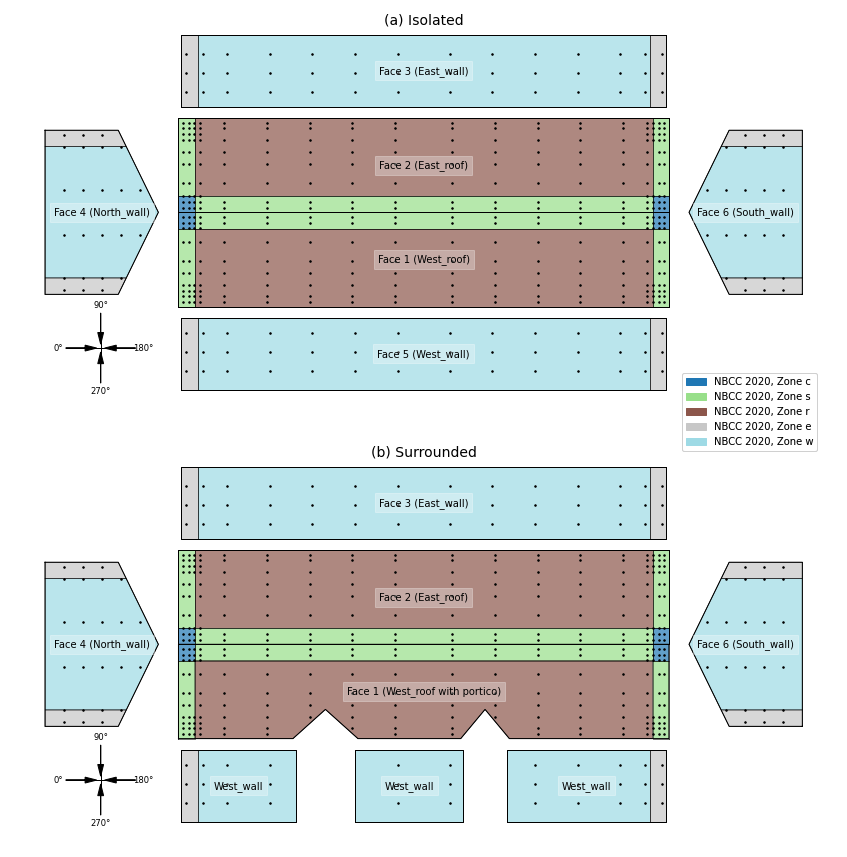

In [22]:
fig = plt.figure(figsize=[12,12])
axs = fig.subplots(2,1)
fig.tight_layout(pad=0.0, w_pad=0.0, h_pad=0.0)

ax = axs[0]
ax.text(0.5, 0.95, '(a) Isolated', transform=ax.transAxes, ha='center', va='bottom', fontsize=14)
bldg_iso.plotEdges(ax=ax,showName=True)
bldg_iso.plotTaps(ax=ax,showTapNo=False)
_, legend, _ = bldg_iso.plotZones(ax=ax)
ax.add_artist(legend)
legend.set_bbox_to_anchor((0.81, 0.11))
bldg_iso.plotAoA_definition(ax=ax, size=0.7, marginFactor=[1.0,0.5])
ax.axis('equal')
ax.axis('off')

ax = axs[1]
ax.text(0.5, 0.95, '(b) Surrounded', transform=ax.transAxes, ha='center', va='bottom', fontsize=14)
bldg_sur.plotEdges(ax=ax,showName=True)
bldg_sur.plotTaps(ax=ax,showTapNo=False)
bldg_sur.plotZones(ax=ax, showLegend=False)
bldg_sur.plotAoA_definition(ax=ax, size=0.7, marginFactor=[1.0,0.5])
ax.axis('equal')
ax.axis('off')

plt.show()

if saveFigs:
    fig.savefig(figDir+"tapLayout.svg",format='svg',dpi=1200, bbox_inches='tight')


In [23]:
print(bldg_iso.NominalPanelArea)

[50.0, 180.0, 470.0, 785.0, 3200, 10000]


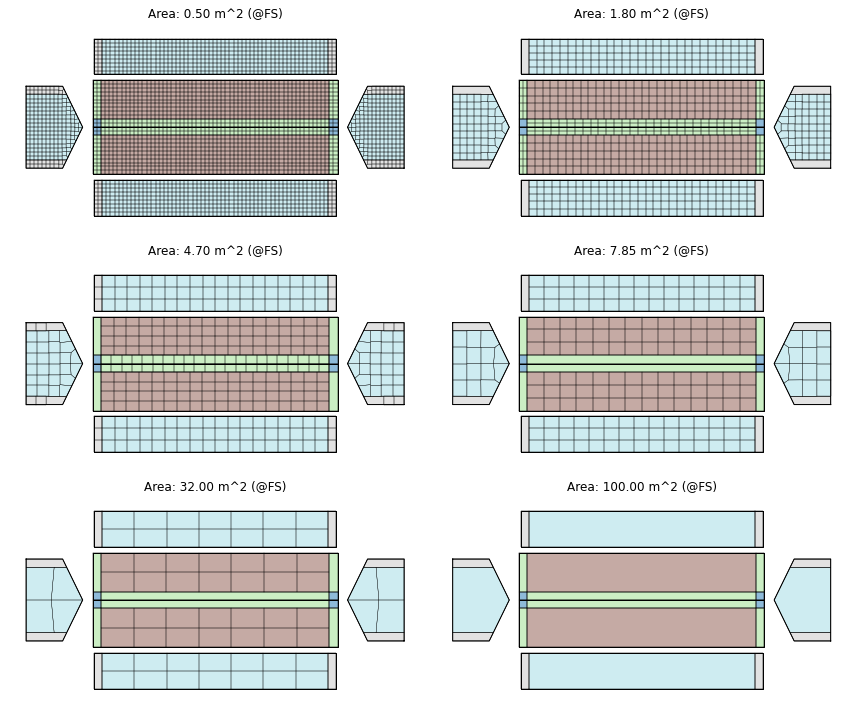

In [24]:
fig, axs = bldg_iso.plotPanels_AllAreas(figsize=[12,10], nCols=2,
    areaUnit='m^2 (@FS)', areaFactor=areaFactor_toFSm2, areaFmt='{:2.2f}',
    kwargs_zoneEdge={'color':'k', 'linewidth':0.3}
    )
if saveFigs:
    fig.savefig(figDir+"nominalPanelAreas.svg",format='svg',dpi=1200, bbox_inches='tight')

# Load and process data

## Field data

In [70]:
fieldDataFile = r"D:/tempData_depot/NRC_data/newBrunswick_output/NewBrunswick_runBulk__Report_Stats.xlsx"
figDir2 = r"D:\OneDrive - The University of Western Ontario\Documents\Projects\NRC_fieldMonitoring\NRC_Docs\reports\figures/"

fs_vel = pd.read_excel(fieldDataFile, sheet_name='Velocity', header=0, index_col=0)

fs_meanCp = pd.read_excel(fieldDataFile, sheet_name='meanCp', header=0, index_col=0)

fs_minPeakCp = pd.read_excel(fieldDataFile, sheet_name='minPeakCp', header=0, index_col=0)

fs_maxPeakCp = pd.read_excel(fieldDataFile, sheet_name='maxPeakCp', header=0, index_col=0)

print(np.shape(fs_meanCp))

AoA = fs_vel['AoA [deg]'] - 5.0  # correct for the 5 deg offset in the field data
refH = 1.0

fs_data = {}
fs_data['mean'] = fs_meanCp.to_numpy()
fs_data['peakMin'] = fs_minPeakCp.to_numpy()
fs_data['peakMax'] = fs_maxPeakCp.to_numpy()

H_FS = 9.81

es85_Fld = wind.ESDU85(z0=0.9)
es85_Fld_obj = es85_Fld.toProfileObj()

N_rows = fs_vel.shape[0]

fieldData = {
    'name': 'Field',
    'AoA':  AoA.to_numpy(),
    'Z':    [1.0],
    'U':    np.ones(N_rows),
    'Iu':   fs_vel['Iu'].to_numpy(),
    'Iv':   fs_vel['Iv'].to_numpy(),
    'Iw':   fs_vel['Iw'].to_numpy(),
    'xLu':  fs_vel['xLu'].to_numpy()/H_FS,
    'xLv':  fs_vel['xLv'].to_numpy()/H_FS,
    'xLw':  fs_vel['xLw'].to_numpy()/H_FS,
}
print(np.shape(fieldData['Z']))

(45, 15)
(1,)


## Wind tunnel


### Wind field

In [25]:
sFreq = 1600
dt = 1/sFreq

pDir =profileDir+"tngE2/"
Z = np.squeeze(pd.read_csv(pDir+"Z.csv"))
U_TH = np.load(pDir+"UofT.npy")
V_TH = np.load(pDir+"VofT.npy")*-1
W_TH = np.load(pDir+"WofT.npy")*-1
vel_OP = wind.profile(name="BLWT - OP", Z=Z,UofT=U_TH,VofT=V_TH,WofT=W_TH,H=H,dt=dt,nSpectAvg=32,keepTH=True)

pDir =profileDir+"tngE3/"
Z = np.squeeze(pd.read_csv(pDir+"Z.csv"))
U_TH = np.load(pDir+"UofT.npy")
V_TH = np.load(pDir+"VofT.npy")*-1
W_TH = np.load(pDir+"WofT.npy")*-1
vel_SU = wind.profile(name="BLWT - SU", Z=Z,UofT=U_TH.transpose(),VofT=V_TH.transpose(),WofT=W_TH.transpose(),H=H,dt=dt,nSpectAvg=32,keepTH=True)

del(U_TH, V_TH, W_TH)

In [61]:
# if exp == 'E2':
#     vel_WT = vel_OP
# elif exp == 'E3':
#     vel_WT = vel_SU
z0_OP = 0.02
z0_SU = 0.2

es85_OP = wind.ESDU85(z0=z0_OP, Zref=H/lScl, Uref=25.0, phi=site_latitude)
es74_OP = wind.ESDU74(z0=z0_OP, Zref=H/lScl, Uref=25.0, phi=site_latitude)
vel_E2_ESDU = es85_OP.toProfileObj()
vel_E2_ESDU.SpectH = es74_OP.toProfileObj().SpectH
vel_E2_ESDU.name = r'ESDU ($z_0='+f"{z0_OP:.2g}"+'m$)'
vel_E2_ESDU.SpectH.name = r'ESDU ($z_0='+f"{z0_OP:.2g}"+'m$)'

es85_SU = wind.ESDU85(z0=z0_SU, Zref=H/lScl, Uref=25.0, phi=site_latitude)
es74_SU = wind.ESDU74(z0=z0_SU, Zref=H/lScl, Uref=25.0, phi=site_latitude)
vel_E3_ESDU = es85_SU.toProfileObj()
vel_E3_ESDU.SpectH = es74_SU.toProfileObj().SpectH
vel_E3_ESDU.name = r'ESDU ($z_0='+f"{z0_SU:.2g}"+'m$)'
vel_E3_ESDU.SpectH.name = r'ESDU ($z_0='+f"{z0_SU:.2g}"+'m$)'

# vel = wind.Profiles([vel_OP, vel_SU, es74_OP.toProfileObj(), es85_OP.toProfileObj(), es74_SU.toProfileObj(), es85_SU.toProfileObj(),])
vel = wind.Profiles([vel_OP, vel_SU, vel_E2_ESDU, vel_E3_ESDU,])
vel_OP_all = wind.Profiles([vel_OP, es74_OP.toProfileObj(), es85_OP.toProfileObj(),])
vel_SU_all = wind.Profiles([vel_SU, es74_SU.toProfileObj(), es85_SU.toProfileObj(),])

### Pressure

In [ ]:
analogChannels_idxs={
                'main_pitot': 0,
                'xcheck_pitot': 2,
            }
pressureExtraChannels_tapNos={
                'main_pitot_zero': 2909,
                'main_pitot_queue': 2910,
                '20inch_pitot_zero': 2907,
                '20inch_pitot_queue': 2908,
                'Uh_pitot_zero': 2905,
                'Uh_pitot_queue': 2906,
            }

peakSpecs = wind.DEFAULT_PEAK_SPECS
peakSpecs['Num_seg'] = 10
peakSpecs['Duration'] = 10
peakSpecs['prob_non_excd'] = 0.8

In [ ]:
cp_raw = wt.BLWTL_HFPI(
    caseDir=casedir_iso_OP,
    userNotes=None,
    Z_MainPitot=1.48,
    analogChannels_idxs=analogChannels_idxs,
    pressureExtraChannels_tapNos=pressureExtraChannels_tapNos,
    lowpassFreq=200.0,
    # lowpassFreq=222.223,
    Ntaps=440,
)
winsound.Beep(1000, 1000)

cp_iso_OP = wind.bldgCp(
                bldgName=bldg_iso.name,
                faces=bldg_iso.faces,
                H=H,D=D,B=B,roofSlope=roofSlope,lScl=lScl,
                AoA_zero_deg_basisVector=bldg_iso.AoA_zero_deg_basisVector,
                AoA_rotation_direction=bldg_iso.AoA_rotation_direction,
                caseName=caseName_iso_OP,
                refProfile=vel_OP,
                Zref_input=cp_raw.Z_MainPitot,
                Uref_input=cp_raw.Uref,
                samplingFreq=cp_raw.sampleRate,
                notes_Cp=cp_raw.description,
                AoA=cp_raw.AoA,
                CpOfT=cp_raw.CpTH,
                badTaps=None,
                reReferenceCpToH=True,
                pOfT=None,
                p0ofT=None,
                CpStats=None,
                peakSpecs=peakSpecs,
                keepTH=False,
                )
winsound.Beep(1000, 1000)

cp_raw = wt.BLWTL_HFPI(
    caseDir=casedir_iso_SU,
    userNotes=None,
    Z_MainPitot=1.48,
    analogChannels_idxs=analogChannels_idxs,
    pressureExtraChannels_tapNos=pressureExtraChannels_tapNos,
    lowpassFreq=200.0,
    # lowpassFreq=222.223,
    Ntaps=440,
)
winsound.Beep(1000, 1000)

cp_iso_SU = wind.bldgCp(
                bldgName=bldg_iso.name,
                faces=bldg_iso.faces,
                H=H,D=D,B=B,roofSlope=roofSlope,lScl=lScl,
                AoA_zero_deg_basisVector=bldg_iso.AoA_zero_deg_basisVector,
                AoA_rotation_direction=bldg_iso.AoA_rotation_direction,
                caseName=caseName_iso_SU,
                refProfile=vel_SU,
                Zref_input=cp_raw.Z_MainPitot,
                Uref_input=cp_raw.Uref,
                samplingFreq=cp_raw.sampleRate,
                AoA=cp_raw.AoA,
                CpOfT=cp_raw.CpTH,
                badTaps=None,
                reReferenceCpToH=True,
                pOfT=None,
                p0ofT=None,
                CpStats=None,
                peakSpecs=peakSpecs,
                keepTH=False,
                )
winsound.Beep(1000, 1000)


Reading HFPI data from: E:/nrcNB_windTunnelData/rawHFPI/nrcNBc2E2/
   Reading file: E:/nrcNB_windTunnelData/rawHFPI/nrcNBc2E2/TSINUELc2E02R001P001a.pssd
   Reading file: E:/nrcNB_windTunnelData/rawHFPI/nrcNBc2E2/TSINUELc2E02R001P002a.pssd
   Reading file: E:/nrcNB_windTunnelData/rawHFPI/nrcNBc2E2/TSINUELc2E02R001P003a.pssd
   Reading file: E:/nrcNB_windTunnelData/rawHFPI/nrcNBc2E2/TSINUELc2E02R001P004a.pssd
   Reading file: E:/nrcNB_windTunnelData/rawHFPI/nrcNBc2E2/TSINUELc2E02R001P005a.pssd
   Reading file: E:/nrcNB_windTunnelData/rawHFPI/nrcNBc2E2/TSINUELc2E02R001P006a.pssd
   Reading file: E:/nrcNB_windTunnelData/rawHFPI/nrcNBc2E2/TSINUELc2E02R001P007a.pssd
   Reading file: E:/nrcNB_windTunnelData/rawHFPI/nrcNBc2E2/TSINUELc2E02R001P008a.pssd
   Reading file: E:/nrcNB_windTunnelData/rawHFPI/nrcNBc2E2/TSINUELc2E02R001P009a.pssd
   Reading file: E:/nrcNB_windTunnelData/rawHFPI/nrcNBc2E2/TSINUELc2E02R001P010a.pssd
   Reading file: E:/nrcNB_windTunnelData/rawHFPI/nrcNBc2E2/TSINUELc2E02R0

In [ ]:
cp_raw = wt.BLWTL_HFPI(
    caseDir=casedir_sur_OP,
    userNotes=None,
    Z_MainPitot=1.48,
    analogChannels_idxs=analogChannels_idxs,
    pressureExtraChannels_tapNos=pressureExtraChannels_tapNos,
    lowpassFreq=200.0,
    # lowpassFreq=222.223,
    Ntaps=440,
)
winsound.Beep(1000, 1000)

cp_sur_OP = wind.bldgCp(
                bldgName=bldg_sur.name,
                faces=bldg_sur.faces,
                H=H,D=D,B=B,roofSlope=roofSlope,lScl=lScl,
                AoA_zero_deg_basisVector=bldg_sur.AoA_zero_deg_basisVector,
                AoA_rotation_direction=bldg_sur.AoA_rotation_direction,
                caseName=caseName_sur_OP,
                refProfile=vel_OP,
                Zref_input=cp_raw.Z_MainPitot,
                Uref_input=cp_raw.Uref,
                samplingFreq=cp_raw.sampleRate,
                AoA=cp_raw.AoA,
                CpOfT=cp_raw.CpTH,
                badTaps=None,
                reReferenceCpToH=True,
                pOfT=None,
                p0ofT=None,
                CpStats=None,
                peakSpecs=peakSpecs,
                keepTH=False,
                )
winsound.Beep(1000, 1000)

cp_raw = wt.BLWTL_HFPI(
    caseDir=casedir_sur_SU,
    userNotes=None,
    Z_MainPitot=1.48,
    analogChannels_idxs=analogChannels_idxs,
    pressureExtraChannels_tapNos=pressureExtraChannels_tapNos,
    lowpassFreq=200.0,
    # lowpassFreq=222.223,
    Ntaps=440,
)
winsound.Beep(1000, 1000)

cp_sur_SU = wind.bldgCp(
                bldgName=bldg_sur.name,
                faces=bldg_sur.faces,
                H=H,D=D,B=B,roofSlope=roofSlope,lScl=lScl,
                AoA_zero_deg_basisVector=bldg_sur.AoA_zero_deg_basisVector,
                AoA_rotation_direction=bldg_sur.AoA_rotation_direction,
                caseName=caseName_sur_SU,
                refProfile=vel_SU,
                Zref_input=cp_raw.Z_MainPitot,
                Uref_input=cp_raw.Uref,
                samplingFreq=cp_raw.sampleRate,
                AoA=cp_raw.AoA,
                CpOfT=cp_raw.CpTH,
                badTaps=None,
                reReferenceCpToH=True,
                pOfT=None,
                p0ofT=None,
                CpStats=None,
                peakSpecs=peakSpecs,
                keepTH=False,
                )
winsound.Beep(1000, 1000)

Reading HFPI data from: E:/nrcNB_windTunnelData/rawHFPI/nrcNBc1E2/
   Reading file: E:/nrcNB_windTunnelData/rawHFPI/nrcNBc1E2/TSINUELc1E02R001P001a.pssd
   Reading file: E:/nrcNB_windTunnelData/rawHFPI/nrcNBc1E2/TSINUELc1E02R001P002a.pssd
   Reading file: E:/nrcNB_windTunnelData/rawHFPI/nrcNBc1E2/TSINUELc1E02R001P003a.pssd
   Reading file: E:/nrcNB_windTunnelData/rawHFPI/nrcNBc1E2/TSINUELc1E02R001P004a.pssd
   Reading file: E:/nrcNB_windTunnelData/rawHFPI/nrcNBc1E2/TSINUELc1E02R001P005a.pssd
   Reading file: E:/nrcNB_windTunnelData/rawHFPI/nrcNBc1E2/TSINUELc1E02R001P006a.pssd
   Reading file: E:/nrcNB_windTunnelData/rawHFPI/nrcNBc1E2/TSINUELc1E02R001P007a.pssd
   Reading file: E:/nrcNB_windTunnelData/rawHFPI/nrcNBc1E2/TSINUELc1E02R001P008a.pssd
   Reading file: E:/nrcNB_windTunnelData/rawHFPI/nrcNBc1E2/TSINUELc1E02R001P009a.pssd
   Reading file: E:/nrcNB_windTunnelData/rawHFPI/nrcNBc1E2/TSINUELc1E02R001P010a.pssd
   Reading file: E:/nrcNB_windTunnelData/rawHFPI/nrcNBc1E2/TSINUELc1E02R0

# Plot results

### Field data only

In [ ]:
# plot wind rose of the field data using circular bins
fig = plt.figure(figsize=[12,12])
ax = fig.subplots(1,1)
fig.tight_layout(pad=0.0, w_pad=0.0, h_pad=0.0)

nBins = 16
binEdges = np.linspace(0,360,nBins+1)
binCenters = (binEdges[1:] + binEdges[:-1])/2
binWidth = binEdges[1] - binEdges[0]
binCounts = np.zeros(nBins)
for i in range(nBins):
    idx = np.where((AoA >= binEdges[i]) & (AoA < binEdges[i+1]))[0]
    binCounts[i] = len(idx)
binCounts = binCounts/np.sum(binCounts)*100

ax.bar(binCenters, binCounts, width=binWidth, color='k', edgecolor='k', alpha=0.5)  
ax.set_xlim([0,360])
ax.set_ylim([0,20])
ax.set_xticks(np.arange(0,361,45))
ax.set_yticks(np.arange(0,21,5))
ax.set_xlabel('Wind direction [deg]')
ax.set_ylabel('Frequency [%]')
ax.set_title('Field data')
ax.grid(True)

### Wind field
#### All profiles

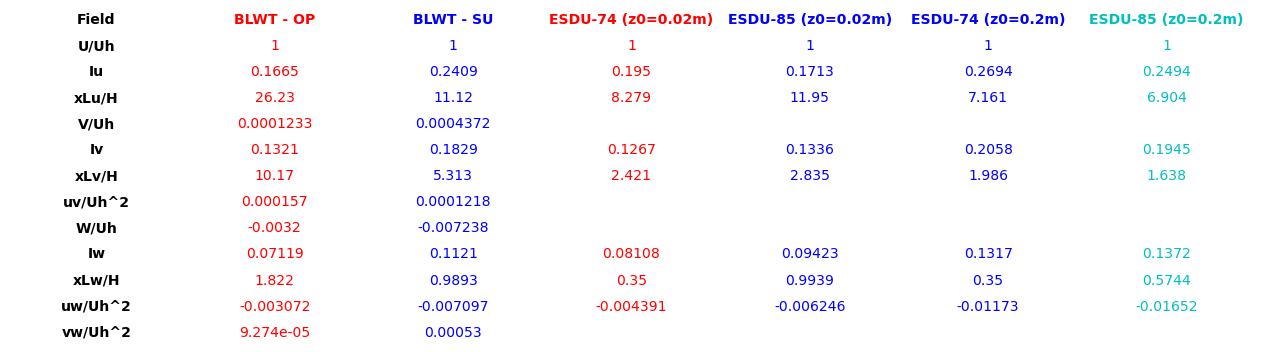

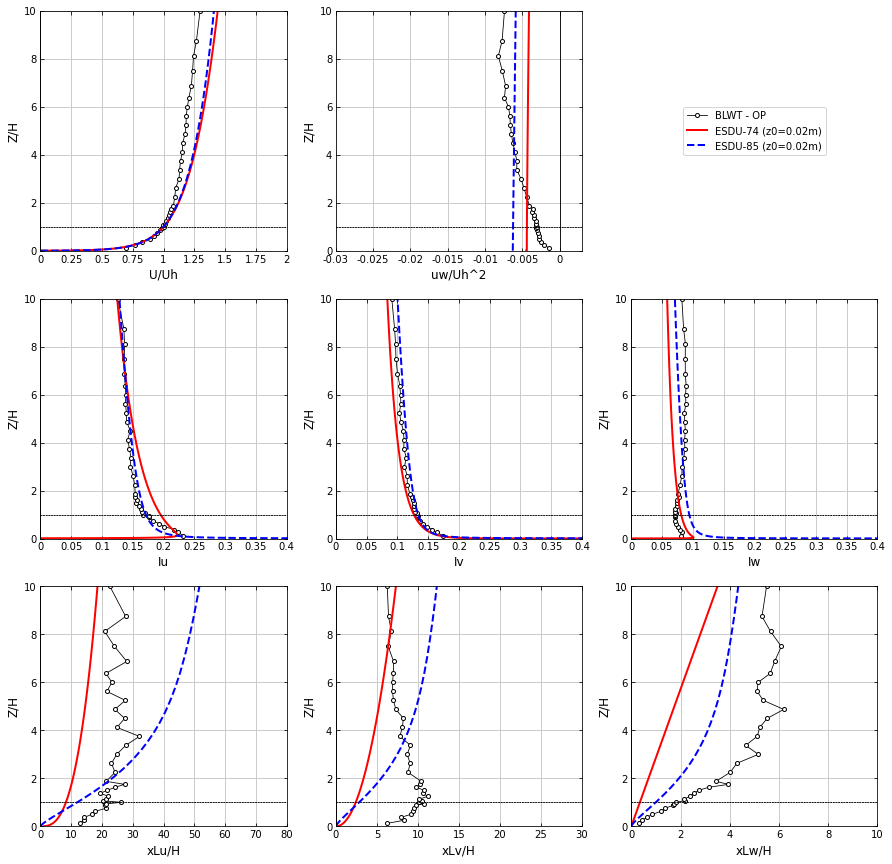

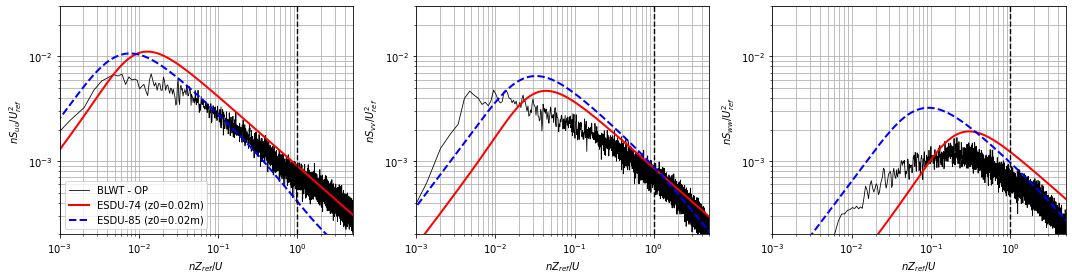

In [59]:
fig, _ = vel.plotRefHeightStatsTable(fontSz=14,figWidthFctr=0.9,
                                     colTxtColors=['r','b','r','b','b','c','r','b','c'],)
# fig.savefig(direct+'kate_refHeightStatsTable.svg', dpi=300, bbox_inches='tight')

kwargs_plt=[{'lw':0.8, 'ls':'-', 'color':'k', 'marker':'o', 'ms':4, 'mfc':'w', }, 
            # {'lw':0.8, 'ls':'-', 'color':'b', 'marker':'d', 'ms':4, 'mfc':'w', },
            {'lw':2, 'ls':'-', 'color':'r'},
            {'lw':2, 'ls':'--', 'color':'b'},
            {'lw':2, 'ls':'-', 'color':'c'},
            {'lw':2, 'ls':'--', 'color':'r'},
            {'lw':2, 'ls':'--', 'color':'b'},
            {'lw':2, 'ls':'--', 'color':'c'},
            ]

fig, _ = vel_OP_all.plotProfile_basic2(figsize=[15,15],
                        yLimits=[0,10],
                        xLimits_U=[0, 2], xLimits_uw=[-0.03, 0.003],
                        xLimits_Iu=[0,0.4], xLimits_Iv=[0,0.4], xLimits_Iw=[0,0.4],
                        xLimits_xLu=[0, 80], xLimits_xLv=[0,30], xLimits_xLw=[0,10],
                        kwargs_plt=kwargs_plt,
                        )
# fig.savefig(direct+'kate_profile_basic2.svg', dpi=300, bbox_inches='tight')

kwargs_sp_plt=[ {'lw':0.8, 'ls':'-', 'color':'k', 'marker':'None', 'ms':4, 'mfc':'w', }, 
                # {'lw':0.8, 'ls':'--', 'color':'b', 'marker':'None', 'ms':4, 'mfc':'w', }, 
                {'lw':2, 'ls':'-', 'color':'r'},
                {'lw':2, 'ls':'--', 'color':'b'},
                {'lw':2, 'ls':'-', 'color':'c'},
                {'lw':2, 'ls':'--', 'color':'r'},
                {'lw':2, 'ls':'--', 'color':'b'},
                {'lw':2, 'ls':'--', 'color':'c'},
                ]
fig = vel_OP_all.plotSpectra(figSize=[15,4], xLimits=[1e-3,5],
                yLimits=[[2e-4,3e-2],[2e-4,3e-2],[2e-4,3e-2]],
                kwargs_plt=kwargs_sp_plt,)
# fig.savefig(direct+'kate_spectra.svg', dpi=300, bbox_inches='tight')

#### Selected profiles and spectra

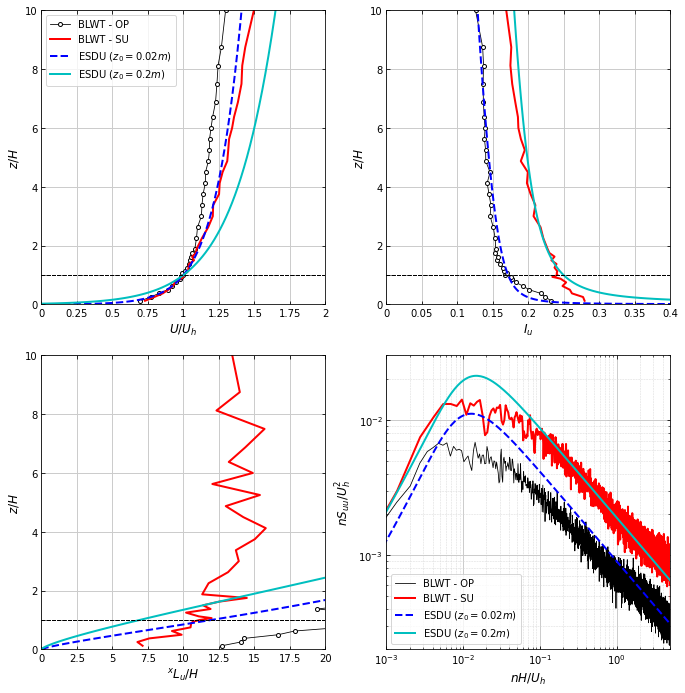

In [62]:
fig, axs = plt.subplots(2,2,figsize=[10,10])
# tight_layout
fig.tight_layout(pad=3.0)

def custom_format(x, pos):
    return f"{x:g}"  # Format the value with 2 decimal places and add ° symbol

kwargs_hline = {'color':'k', 'lw':1.0, 'ls':'--'}
for i, prof in enumerate(vel.profiles):
    ax = axs[0,0]
    ax.plot(prof.UbyUh, prof.ZbyH, label=prof.name, **kwargs_plt[i])
    ax.axhline(1.0, **kwargs_hline)
    ax.legend()
    ax.set_xlabel(r'$U/U_h$')
    ax.set_ylabel(r'$z/H$')
    ax.set_xlim([0,2])
    ax.set_ylim([0,10])
    wind.formatAxis(ax, gridMajor=True, gridMinor=True)

    ax = axs[0,1]
    ax.plot(prof.Iu, prof.ZbyH, **kwargs_plt[i])
    ax.axhline(1.0, **kwargs_hline)
    ax.set_xlabel(r'$I_u$')
    ax.set_ylabel(r'$z/H$')
    ax.set_xlim([0,0.4])
    ax.set_ylim([0,10])
    wind.formatAxis(ax, gridMajor=True, gridMinor=True)

    ax = axs[1,0]
    ax.plot(prof.xLuByH, prof.ZbyH, **kwargs_plt[i])
    ax.axhline(1.0, **kwargs_hline)
    ax.set_xlabel(r'$^xL_u/H$')
    ax.set_ylabel(r'$z/H$')
    ax.set_xlim([0,20])
    ax.set_ylim([0,10])
    wind.formatAxis(ax, gridMajor=True, gridMinor=True)

    ax = axs[1,1]
    ax.loglog(prof.SpectH.rf(), prof.SpectH.rSuu(), label=prof.name, **kwargs_sp_plt[i])
    ax.legend()
    ax.set_xlabel(r'$nH/U_h$')
    ax.set_ylabel(r'$nS_{uu}/U_h^2$')
    ax.set_xlim([1e-3,5])
    ax.set_ylim([2e-4,3e-2])
    wind.formatAxis(ax, gridMajor=True, gridMinor=True, numFormat='default')

plt.show()
# fig.savefig(direct+'kate_concise.svg', dpi=300, bbox_inches='tight')

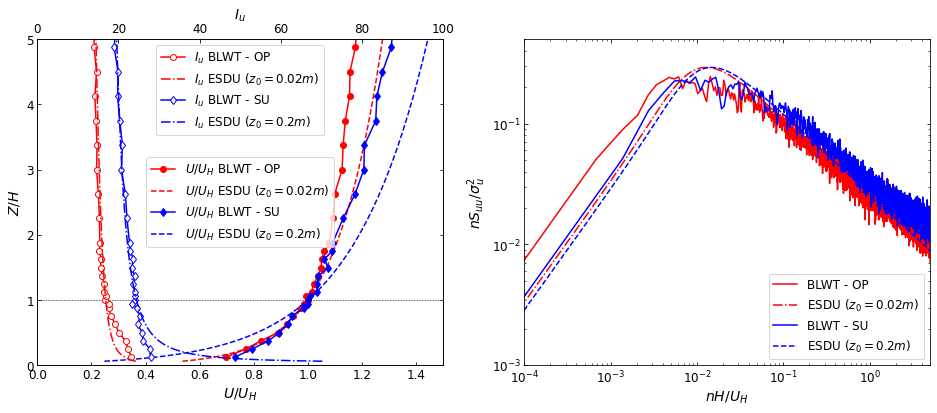

In [18]:
fig = vel.plot__(fig=plt.figure(figsize=[16,6]),zLim=[0,5], IuLim=[0,100], Ulim=[0,1.5],
        col=['r','r','b','b','g','g'],
        marker_Iu=   ['o','None','d','None','v','None'],
        linestyle_Iu=['-','-.',  '-','-.',  '-','--'],
        marker_U=    ['o','None','d','None','v','None'],
        linestyle_U= ['-','--',  '-','--',  '-','--'],
        marker_Spect=   ['None','None','None','None','None','None'],
        linestyle_Spect=['-','-.',  '-','--',  '-','--'],
        alpha_Spect=[0.5, 1.0, 0.5, 1.0],
        IuLgndLoc='upper center', UlgndLoc='center',
        fontSz_axLbl=14, fontSz_axNum=12, fontSz_lgnd=12,
        freqLim=[1e-4, 5], rSuuLim=[1e-3,0.5]
        )
# if saveFigs:
#     fig.savefig(figDir+"windField.svg",format='svg',dpi=1200, bbox_inches='tight')

#### WT vs. Field vs. ESDU  (bulky)

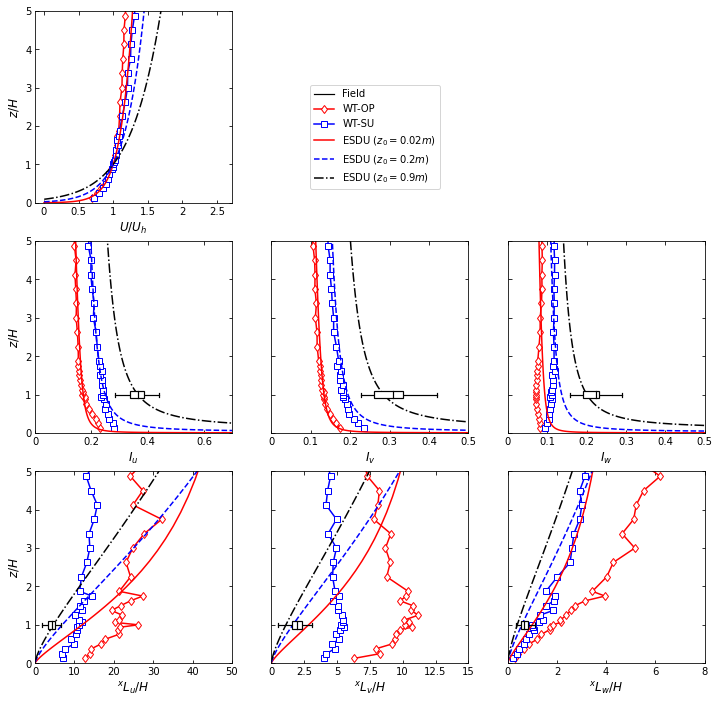

In [66]:
# fig = plt.figure(figsize=[13,8])
fig, axs = plt.subplots(3,3, figsize=[12,12], sharey=True)

zMax = 5
yticks = np.linspace(0,zMax,6)

fldLW = 1.2

ax = axs[0,0]
ax.plot(vel_OP.UbyUh, vel_OP.ZbyH, 'd-r', label='WT-OP', markersize=6, markerfacecolor='w')
ax.plot(vel_SU.UbyUh, vel_SU.ZbyH, 's-b', label='WT-SU', markersize=6, markerfacecolor='w')
ax.plot(vel_E2_ESDU.UbyUh, vel_E2_ESDU.ZbyH, '-r', label=r'ESDU ($z_0=0.02m$)')
ax.plot(vel_E3_ESDU.UbyUh, vel_E3_ESDU.ZbyH, '--b', label=r'ESDU ($z_0=0.2m$)')
ax.plot(es85_Fld_obj.UbyUh, es85_Fld_obj.ZbyH, '-.k', label=r'ESDU ($z_0=0.9m$)')
ax.set_xlabel(r"$U/U_h$")
ax.set_ylabel(r"$z/H$")
ax.set_yticks(yticks)
ax.set_yticklabels([f"{y:.1f}" for y in yticks])
ax.set_ylim([0,zMax])
wind.formatAxis(ax, gridMajor=False, gridMinor=False)

axs[0,1].axis('off')
axs[0,2].axis('off')

ax = axs[1,0]
# ax.plot(fs_vel['Iu'], np.ones_like(fs_vel['Iu']), '.k', label='Field')
ax.plot([0,0.5], [-100, -100], '-k', label='Field', linewidth=fldLW)
ax.plot(vel_OP.Iu, vel_OP.ZbyH, 'd-r', label='WT-OP', markersize=6, markerfacecolor='w')
ax.plot(vel_SU.Iu, vel_SU.ZbyH, 's-b', label='WT-SU', markersize=6, markerfacecolor='w')
ax.plot(vel_E2_ESDU.Iu, vel_E2_ESDU.ZbyH, '-r', label=r'ESDU ($z_0=0.02m$)')
ax.plot(vel_E3_ESDU.Iu, vel_E3_ESDU.ZbyH, '--b', label=r'ESDU ($z_0=0.2m$)')
ax.plot(es85_Fld_obj.Iu, es85_Fld_obj.ZbyH, '-.k', label=r'ESDU ($z_0=0.9m$)')
ax.boxplot(fs_vel['Iu'], vert=False, positions=[1], widths=0.2, showfliers=False, patch_artist=True, meanline=True, #showmeans=True,
           boxprops=dict(facecolor='w', color='k', linewidth=fldLW), medianprops=dict(color='k', linewidth=fldLW), whiskerprops=dict(color='k', linewidth=fldLW), 
           capprops=dict(color='k', linewidth=fldLW))
ax.set_xlabel(r"$I_u$")
ax.set_ylabel(r"$z/H$")
ax.set_xlim([0.0,0.7])
ax.set_ylim([0,zMax])
ax.set_yticks(np.arange(0,zMax+1,1))
ax.set_yticklabels(np.arange(0,zMax+1,1))
# ax.legend()
wind.formatAxis(ax, gridMajor=False, gridMinor=False)
legend_handles, legend_labels = ax.get_legend_handles_labels()
fig.legend(legend_handles, legend_labels, loc='upper right', ncol=1, bbox_to_anchor=(0.6, 0.8), frameon=True)

ax = axs[1,1]
# ax.plot(fs_vel['Iv'], np.ones_like(fs_vel['Iv']), '.k', label='Field')
ax.plot(vel_OP.Iv, vel_OP.ZbyH, 'd-r', label='WT-OP', markersize=6, markerfacecolor='w')
ax.plot(vel_SU.Iv, vel_SU.ZbyH, 's-b', label='WT-SU', markersize=6, markerfacecolor='w')
ax.plot(vel_E2_ESDU.Iv, vel_E2_ESDU.ZbyH, '-r', label=r'ESDU ($z_0=0.02m$)')
ax.plot(vel_E3_ESDU.Iv, vel_E3_ESDU.ZbyH, '--b', label=r'ESDU ($z_0=0.2m$)')
ax.plot(es85_Fld_obj.Iv, es85_Fld_obj.ZbyH, '-.k', label=r'ESDU ($z_0=0.9m$)')
ax.boxplot(fs_vel['Iv'], vert=False, positions=[1], widths=0.2, showfliers=False, patch_artist=True, meanline=True, #showmeans=True,
           boxprops=dict(facecolor='w', color='k', linewidth=fldLW), medianprops=dict(color='k', linewidth=fldLW), whiskerprops=dict(color='k', linewidth=fldLW), 
           capprops=dict(color='k', linewidth=fldLW))
ax.set_xlabel(r"$I_v$")
# ax.set_ylabel(r"$z/H$")
ax.set_xlim([0.0,0.5])
ax.set_ylim([0,zMax])
ax.set_yticks(np.arange(0,zMax+1,1))
ax.set_yticklabels(np.arange(0,zMax+1,1))
wind.formatAxis(ax, gridMajor=False, gridMinor=False)

ax = axs[1,2]
# ax.plot(fs_vel['Iw'], np.ones_like(fs_vel['Iw']), '.k', label='Field')
ax.plot(vel_OP.Iw, vel_OP.ZbyH, 'd-r', label='WT-OP', markersize=6, markerfacecolor='w')
ax.plot(vel_SU.Iw, vel_SU.ZbyH, 's-b', label='WT-SU', markersize=6, markerfacecolor='w')
ax.plot(vel_E2_ESDU.Iw, vel_E2_ESDU.ZbyH, '-r', label=r'ESDU ($z_0=0.02m$)')
ax.plot(vel_E3_ESDU.Iw, vel_E3_ESDU.ZbyH, '--b', label=r'ESDU ($z_0=0.2m$)')
ax.plot(es85_Fld_obj.Iw, es85_Fld_obj.ZbyH, '-.k', label=r'ESDU ($z_0=0.9m$)')
ax.boxplot(fs_vel['Iw'], vert=False, positions=[1], widths=0.2, showfliers=False, patch_artist=True, meanline=True, #showmeans=True,
           boxprops=dict(facecolor='w', color='k', linewidth=fldLW), medianprops=dict(color='k', linewidth=fldLW), whiskerprops=dict(color='k', linewidth=fldLW), 
           capprops=dict(color='k', linewidth=fldLW))
ax.set_xlabel(r"$I_w$")
# ax.set_ylabel(r"$z/H$")
ax.set_xlim([0.0,0.5])
ax.set_ylim([0,zMax]) 
ax.set_yticks(np.arange(0,zMax+1,1))
ax.set_yticklabels(np.arange(0,zMax+1,1))
wind.formatAxis(ax, gridMajor=False, gridMinor=False)

ax = axs[2,0]
# ax.plot(fs_vel['xLu']/H_FS, np.ones_like(fs_vel['xLu']), '.k', label='Field')
ax.plot(vel_OP.xLuByH, vel_OP.ZbyH, 'd-r', label='WT-OP', markersize=6, markerfacecolor='w')
ax.plot(vel_SU.xLuByH, vel_SU.ZbyH, 's-b', label='WT-SU', markersize=6, markerfacecolor='w')
ax.plot(vel_E2_ESDU.xLuByH, vel_E2_ESDU.ZbyH, '-r', label=r'ESDU ($z_0=0.02m$)')
ax.plot(vel_E3_ESDU.xLuByH, vel_E3_ESDU.ZbyH, '--b', label=r'ESDU ($z_0=0.2m$)')
ax.plot(es85_Fld_obj.xLuByH, es85_Fld_obj.ZbyH, '-.k', label=r'ESDU ($z_0=0.9m$)')
ax.boxplot(fs_vel['xLu']/H_FS, vert=False, positions=[1], widths=0.2, showfliers=False, patch_artist=True, meanline=True, #showmeans=True,
              boxprops=dict(facecolor='w', color='k', linewidth=fldLW), medianprops=dict(color='k', linewidth=fldLW), whiskerprops=dict(color='k', linewidth=fldLW),
                capprops=dict(color='k', linewidth=fldLW))
ax.set_xlabel(r"$^xL_u/H$")
ax.set_ylabel(r"$z/H$")
ax.set_xlim([0.0,50.0])
ax.set_ylim([0,zMax])
ax.set_yticks(np.arange(0,zMax+1,1))
ax.set_yticklabels(np.arange(0,zMax+1,1))
wind.formatAxis(ax, gridMajor=False, gridMinor=False)

ax = axs[2,1]
# ax.plot(fs_vel['xLu']/H_FS, np.ones_like(fs_vel['xLu']), '.k', label='Field')
ax.plot(vel_OP.xLvByH, vel_OP.ZbyH, 'd-r', label='WT-OP', markersize=6, markerfacecolor='w')
ax.plot(vel_SU.xLvByH, vel_SU.ZbyH, 's-b', label='WT-SU', markersize=6, markerfacecolor='w')
ax.plot(vel_E2_ESDU.xLvByH, vel_E2_ESDU.ZbyH, '-r', label=r'ESDU ($z_0=0.02m$)')
ax.plot(vel_E3_ESDU.xLvByH, vel_E3_ESDU.ZbyH, '--b', label=r'ESDU ($z_0=0.2m$)')
ax.plot(es85_Fld_obj.xLvByH, es85_Fld_obj.ZbyH, '-.k', label=r'ESDU ($z_0=0.9m$)')
ax.boxplot(fs_vel['xLv']/H_FS, vert=False, positions=[1], widths=0.2, showfliers=False, patch_artist=True, meanline=True, #showmeans=True,
                boxprops=dict(facecolor='w', color='k', linewidth=fldLW), medianprops=dict(color='k', linewidth=fldLW), whiskerprops=dict(color='k', linewidth=fldLW),
                capprops=dict(color='k', linewidth=fldLW))
ax.set_xlabel(r"$^xL_v/H$")
# ax.set_ylabel(r"$z/H$")
ax.set_xlim([0.0,15.0])
ax.set_ylim([0,zMax])
ax.set_yticks(np.arange(0,zMax+1,1))
ax.set_yticklabels(np.arange(0,zMax+1,1))
wind.formatAxis(ax, gridMajor=False, gridMinor=False)

ax = axs[2,2]
# ax.plot(fs_vel['xLu']/H_FS, np.ones_like(fs_vel['xLu']), '.k', label='Field')
ax.plot(vel_OP.xLwByH, vel_OP.ZbyH, 'd-r', label='WT-OP', markersize=6, markerfacecolor='w')
ax.plot(vel_SU.xLwByH, vel_SU.ZbyH, 's-b', label='WT-SU', markersize=6, markerfacecolor='w')
ax.plot(vel_E2_ESDU.xLwByH, vel_E2_ESDU.ZbyH, '-r', label=r'ESDU ($z_0=0.02m$)')
ax.plot(vel_E3_ESDU.xLwByH, vel_E3_ESDU.ZbyH, '--b', label=r'ESDU ($z_0=0.2m$)')
ax.plot(es85_Fld_obj.xLwByH, es85_Fld_obj.ZbyH, '-.k', label=r'ESDU ($z_0=0.9m$)')
ax.boxplot(fs_vel['xLw']/H_FS, vert=False, positions=[1], widths=0.2, showfliers=False, patch_artist=True, meanline=True, #showmeans=True,
                boxprops=dict(facecolor='w', color='k', linewidth=fldLW), medianprops=dict(color='k', linewidth=fldLW), whiskerprops=dict(color='k', linewidth=fldLW),
                capprops=dict(color='k', linewidth=fldLW))
ax.set_xlabel(r"$^xL_w/H$")
# ax.set_ylabel(r"$z/H$")
ax.set_xlim([0.0,8.0])
ax.set_ylim([0,zMax])
ax.set_yticks(np.arange(0,zMax+1,1))
ax.set_yticklabels(np.arange(0,zMax+1,1))
wind.formatAxis(ax, gridMajor=False, gridMinor=False)


fig.savefig(figDir+f"windTunnel_vs_field__profiles.svg",format='svg',dpi=1200, bbox_inches='tight')

#### WT vs. Field vs. ESDU  (compact)

Overlaying something ...
Overlaying something ...
Overlaying something ...
Overlaying something ...
Overlaying something ...
Overlaying something ...
Overlaying something ...
Overlaying something ...


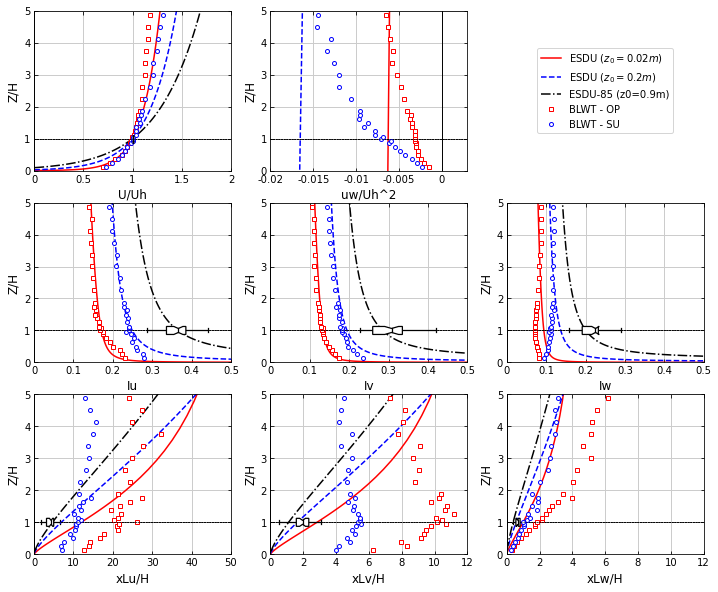

In [69]:
profs = wind.Profiles([vel_E2_ESDU, vel_E3_ESDU, es85_Fld_obj, vel_OP, vel_SU, ])

fig, axs = profs.plotProfile_basic2(yLimits=[0,5],
          xLimits_U=[0, 2], xLimits_uw=[-0.02, 0.003], 
          xLimits_Iu=[0,0.5], xLimits_Iv=[0,0.5], xLimits_Iw=[0,0.5], 
          xLimits_xLu=[0, 50], xLimits_xLv=[0,12], xLimits_xLw=[0,12], 
          kwargs_plt=[{'color': 'r', 'linewidth':1.5, 'linestyle': '-',       'marker': 'None', 'markersize':6, 'markerfacecolor':'w'},
                      {'color': 'b', 'linewidth':1.5, 'linestyle': '--',      'marker': 'None', 'markersize':6, 'markerfacecolor':'w'},
                      {'color': 'k', 'linewidth':1.5, 'linestyle': '-.',      'marker': 'None', 'markersize':6, 'markerfacecolor':'w'},
                      {'color': 'r', 'linewidth':0.5, 'linestyle': 'None',    'marker': 's', 'markersize':4, 'markerfacecolor':'w'},
                      {'color': 'b', 'linewidth':0.5, 'linestyle': 'None',    'marker': 'o', 'markersize':4, 'markerfacecolor':'w'},
                      ],
          overlayThese=fieldData, overlayType='errorBars', 
          # kwargs_overlay={'color': 'k', 'linewidth':0.5, 'linestyle': '-', 'capsize': 5},
                      )
# profs.plotSpectra(figSize=[15,5],
#                   xLimits=[5e-4, 1e1],
#                     yLimits=[[1e-4,1e-1],[1e-4,1e-1],[1e-4,1e-1]],
#                     )


### $C_p$ contours

Figure saved to D:/OneDrive - The University of Western Ontario/Documents/Projects/NRC_fieldMonitoring/NRC_gable27deg/Data/windTunnel/gable27deg/__plots/CpContour.svg


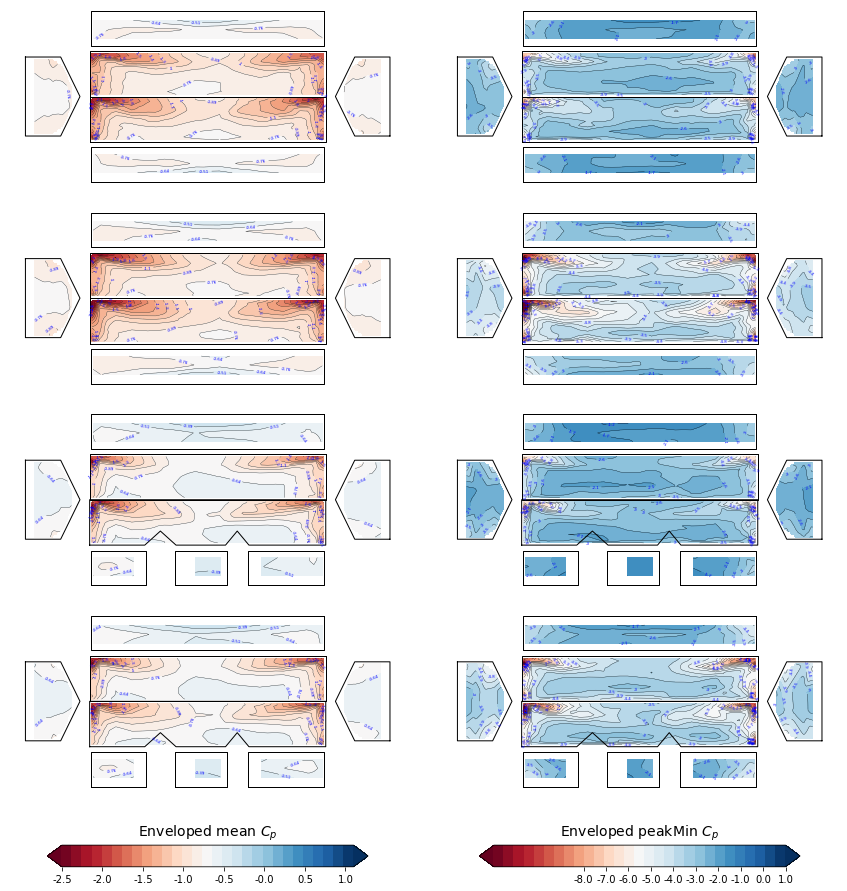

In [28]:
from matplotlib.ticker import FuncFormatter

fig, axs = plt.subplots(5,2,figsize=[12,14])
ax_cbar1 = axs[4,0]
ax_cbar2 = axs[4,1]
fig.tight_layout(pad=0.0, w_pad=0.0, h_pad=0.0)

for i, cp in enumerate([cp_iso_OP, cp_iso_SU, cp_sur_OP, cp_sur_SU]):

    # fld, fldrange, ticks = 'mean', [-2.5, 1.1], np.linspace(-2.5,1.0,8)
    fld, fldrange, ticks = 'mean', [-2.5, 1.1], np.linspace(-2.5,1.0,8)
    
    ax = axs[i,0]
    im = cp.plotTapCpStatContour(ax=ax, envelopeType='low',fieldName=fld,fldRange=fldrange,nLvl=30,title=fld+r" $C_p$")
    cp.plotEdges(ax=ax, showName=False)
    ax.axis('equal')
    ax.axis('off')
    # cbar = fig.colorbar(im[0], ax=ax, orientation='vertical',aspect=20,shrink=0.5,pad=0.0)
    # cbar.set_label(fld+r" $C_p$", fontsize=14, rotation=270, labelpad=20)
    # cbar.ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.2f}'))
    if i == 3:
        ax_cbar1.axis('on')
        cbar = fig.colorbar(im[0], cax=ax_cbar1, orientation='horizontal',aspect=20,shrink=0.5,pad=0.08)
        cbar.set_ticks(ticks)
        cbar.ax.set_xlabel("Enveloped "+fld+r" $C_p$", fontsize=14, rotation=0, labelpad=10)
        cbar.ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.1f}'))
        cbar.ax.xaxis.set_label_position('top')
        pos = ax_cbar1.get_position()
        new_pos = [pos.x0+pos.width*0.1, pos.y0+pos.height*0.7, pos.width*0.8, pos.height*0.12]
        ax_cbar1.set_position(new_pos)

    # cbar.ax.tick_params(labeltop=True, top=True)
    # cbar.ax.set_ylabel('Label', rotation=270, labelpad=15)
    # cbar.ax.set_title('Title', rotation=270, pad=20)
    # if saveFigs:
    #     fig.savefig(figDir+f"{casedir_iso}_Cp_{fld}.svg",format='svg',dpi=1200, bbox_inches='tight')


    fld, fldrange, ticks = 'peakMin', [-12., 1.], np.linspace(-8,1.0,10)

    ax = axs[i,1]
    im = cp.plotTapCpStatContour(ax=ax, envelopeType='low',fieldName=fld,fldRange=fldrange,nLvl=30,title=fld+r" $C_p$")
    cp.plotEdges(ax=ax, showName=False)
    ax.axis('equal')
    ax.axis('off')
    if i == 3:
        ax_cbar2.axis('on')
        cbar = fig.colorbar(im[0], cax=ax_cbar2, orientation='horizontal',aspect=20,shrink=0.7,pad=0.08)
        cbar.set_ticks(ticks)
        cbar.ax.set_xlabel("Enveloped "+fld+r" $C_p$", fontsize=14, rotation=0, labelpad=10)
        cbar.ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.1f}'))
        cbar.ax.xaxis.set_label_position('top')
        pos = ax_cbar2.get_position()
        new_pos = [pos.x0+pos.width*0.1, pos.y0+pos.height*0.7, pos.width*0.8, pos.height*0.12]
        ax_cbar2.set_position(new_pos)
if saveFigs:
    fileName = figDir+f"CpContour.svg"
    fig.savefig(fileName,format='svg',dpi=1200, bbox_inches='tight')
    print(f"Figure saved to {fileName}")
    

### $C_p$ vs. AoA per tap

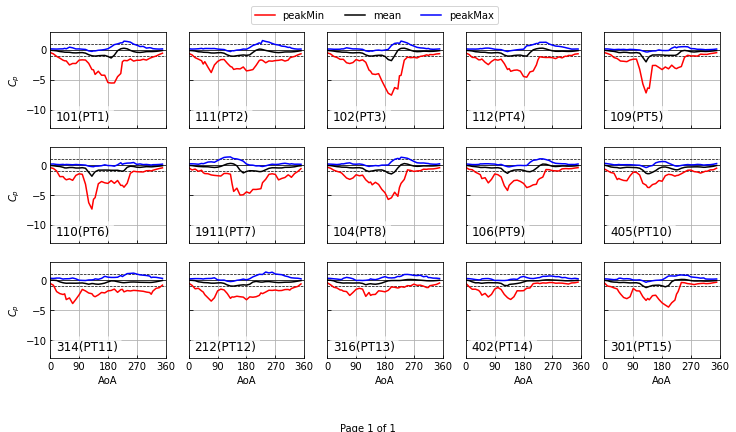

In [23]:
# figs = cp.plotTapCpStatsPerAoA(xticks=np.linspace(0,360,5),pageNo_xy=(0.5,0.06),nCols=7, figsize=[20,20],mrkrs=['None','None','None'], fldRange=[-13,3])#,fields=['mean','std'])

tapsToPlot=[101, 111, 102, 112, 109, 110, 1911, 104, 106, 405, 314, 212, 316, 402, 301]
figs, all_axes = cp_iso_OP.plotTapCpStatsPerAoA(tapsToPlot=tapsToPlot,
                xticks=np.linspace(0,360,5),pageNo_xy=(0.5,0.02),nCols=5, nRows=3, figsize=[12,6],mrkrs=['None','None','None'], fldRange=[-13,3],
                legend_bbox_to_anchor=(0.5, 0.95))#,fields=['mean','std'])

# cp_iso_SU.plotTapCpStatsPerAoA(tapsToPlot=tapsToPlot,
#                 xticks=np.linspace(0,360,5),pageNo_xy=(0.5,0.02),nCols=5, nRows=3, figsize=[12,6],mrkrs=['None','None','None'], fldRange=[-13,3],
#                 legend_bbox_to_anchor=(0.5, 0.95), figs=figs, all_axes=all_axes)#,fields=['mean','std'])

# if saveFigs:
#     for p,fig in enumerate(figs):
#         fig.savefig(figDir+f"nrcNB{caseID}{exp}_CpStatsPerAoA_pg_{p+1}.svg",format='svg',dpi=1200, bbox_inches='tight')


### C&C pressure coefficients from codes

In [ ]:
# val = wind.NBCC2020_CpCg(Figure='4.1.7.6.-E', subfig='a')
# # print(json.dumps(val, indent=4))

# print(wind.getDurstFactor(3.0)**2)


# cp_iso_OP.plotPanelCpStatContour(fieldName='mean')

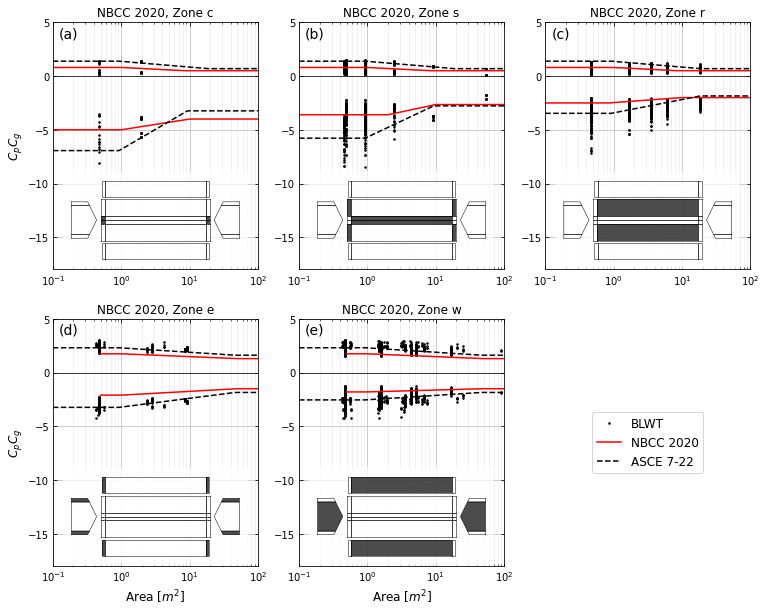

Saved figure: D:/OneDrive - The University of Western Ontario/Documents/Projects/NRC_fieldMonitoring/NRC_gable27deg/Data/windTunnel/gable27deg/__plots/CandC_Fig_E_iso.svg


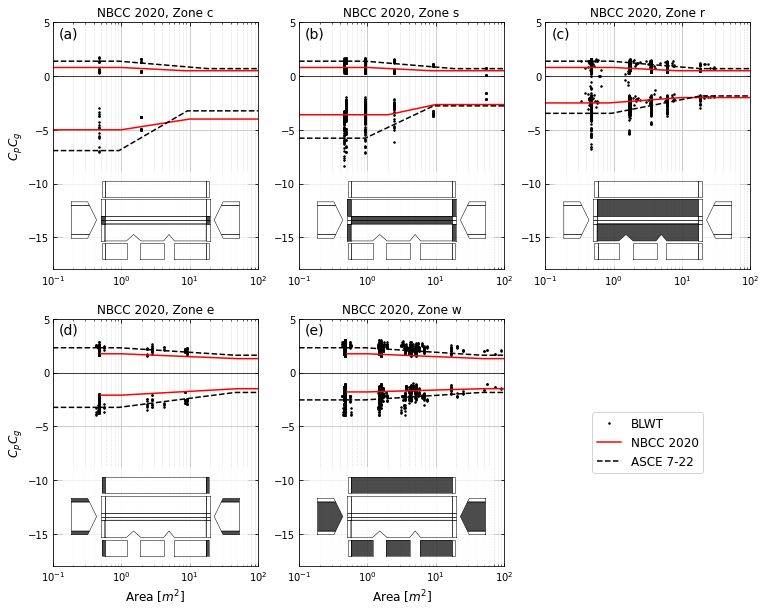

Saved figure: D:/OneDrive - The University of Western Ontario/Documents/Projects/NRC_fieldMonitoring/NRC_gable27deg/Data/windTunnel/gable27deg/__plots/CandC_Fig_E_sur.svg


In [ ]:
directionalityFactor = 1.0 #0.85
fig, axs = cp_iso_OP.plotCandC_load(figSize=[12.5,10], sharex=False, sharey=False,
                                    plotExtremesPerNominalArea=False, areaFactor=areaFactor_toFSm2,
                                    xLimits=[0.1,100], yLimits=[-18,5],
                                    yLabel=r"$C_pC_g$",
                                    label_min=r"BLWT", label_max=None,
                                    kwargs_min={'color':'k', 'marker':'.', 'markersize':3,}, # 'linestyle':'-'},
                                    kwargs_max={'color':'k', 'marker':'.', 'markersize':3,}, # 'linestyle':'-'},
                                    overlayThese=[wind.NBCC2020_CpCg(Figure='4.1.7.6.-E', subfig='a'),  wind.ASCE7_22_GCp(Figure='30.3-2C', subfig='a')],
                                    overlayFactors=[1.0/directionalityFactor,                           (wind.getDurstFactor(3.0))**2],
                                    kwargs_overlay=({'color':'r',}, {'color':'k', 'linestyle':'--'}),
                                    legend_ax_idx=5,
                                    kwargs_legend={'loc':'center', 'fontsize':12},
                                    subplotLabels=['(a)','(b)','(c)','(d)','(e)',''], subplotLabels_xy=[0.03,0.94],
                                    kwargs_ax={'gridMinor':True},
                                    insetBounds=[0.05,0.0,0.9,0.4],
                                    zoneShadeColor='k',
                                    )

if saveFigs:
    fig.savefig(figDir+"CandC_Fig_E_iso.svg",format='svg',dpi=1200, bbox_inches='tight')
    print(f"Saved figure: {figDir}CandC_Fig_E_iso.svg")

fig, axs = cp_sur_OP.plotCandC_load(figSize=[12.5,10], sharex=False, sharey=False,
                                    plotExtremesPerNominalArea=False, areaFactor=areaFactor_toFSm2,
                                    xLimits=[0.1,100], yLimits=[-18,5],
                                    yLabel=r"$C_pC_g$",
                                    label_min=r"BLWT", label_max=None,
                                    kwargs_min={'color':'k', 'marker':'.', 'markersize':3,}, # 'linestyle':'-'},
                                    kwargs_max={'color':'k', 'marker':'.', 'markersize':3,}, # 'linestyle':'-'},
                                    overlayThese=[wind.NBCC2020_CpCg(Figure='4.1.7.6.-E', subfig='a'),  wind.ASCE7_22_GCp(Figure='30.3-2C', subfig='a')],
                                    overlayFactors=[1.0/directionalityFactor,                           (wind.getDurstFactor(3.0))**2],
                                    kwargs_overlay=({'color':'r',}, {'color':'k', 'linestyle':'--'}),
                                    legend_ax_idx=5,
                                    kwargs_legend={'loc':'center', 'fontsize':12},
                                    subplotLabels=['(a)','(b)','(c)','(d)','(e)',''], subplotLabels_xy=[0.03,0.94],
                                    kwargs_ax={'gridMinor':True},
                                    insetBounds=[0.05,0.0,0.9,0.4],
                                    zoneShadeColor='k',
                                    )
if saveFigs:
    fig.savefig(figDir+"CandC_Fig_E_sur.svg",format='svg',dpi=1200, bbox_inches='tight')
    print(f"Saved figure: {figDir}CandC_Fig_E_sur.svg")
